In [1]:
import sys
import numpy as np
sys.path.insert(0, '/home/david/Institut/rydanalysis/')
from rydanalysis import *
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
from scipy import interpolate
mpl.rc('image', cmap='afmhot')
sns.set_style("whitegrid")
from lmfit import Model,Parameters

In [2]:
from scipy import ndimage

In [3]:
seq = ExpSequence("/home/david/Institut/2019_IEI_new/July/16/The-truth-about-LZ")
#shot = SingleShot("/home/david/Institut/2019_IEI/July/02/scanblueresonance_FINAL_averaged_images/2019-06-05_00.fts")

In [4]:
variables= seq.variables.copy()
variables.insert(0,'fitted_amp',0)
variables.insert(0,'pixel_sum',0)

for i,shot in enumerate(seq.iter_single_shots()):
    image=shot.image
    absorb = calc_absorbtion_image(image)
    absorb = crop_image(absorb,xslice=slice(10,90),yslice=slice(10,380))
    od = absorbtion_to_OD(absorb)
    shot.optical_density = od

/home/david/Institut/rydanalysis/rydanalysis/single_shot/image_processing.py:20: RuntimeWarning: divide by zero encountered in true_divide
  trans = atoms/light
/home/david/Institut/rydanalysis/rydanalysis/single_shot/image_processing.py:20: RuntimeWarning: invalid value encountered in true_divide
  trans = atoms/light
/home/david/Institut/rydanalysis/rydanalysis/single_shot/image_processing.py:22: RuntimeWarning: invalid value encountered in greater_equal
  np.place(trans,trans>=1,1)


In [5]:
#od = ndimage.gaussian_filter(od, 4, order=0, output=None, mode='constant', cval=0.0, truncate=4.0)

def fit2dGaussian(image):
    image = ndimage.gaussian_filter(image, 8, order=0, output=None, mode='constant', cval=0.0, truncate=4.0)
    fit = Fit2dGaussian(image)
    fit.params = fit.guess(image)
    #fit.params = restrict_to_init(fit.params,dev=0.2)
    #fit.params['amp'].max = fit.params['amp'].value*(1+0.5)
    #fit.params['amp'].min = fit.params['amp'].value*(1-0.5)
    #fit.params['cen_x'].max = fit.params['amp'].value*(1+0.1)
    #fit.params['cen_x'].min = fit.params['amp'].value*(1-0.1)
    #fit.params['cen_y'].max = fit.params['amp'].value*(1+0.1)
    #fit.params['cen_y'].min = fit.params['amp'].value*(1-0.1)
    #fit.params['offset'].max = fit.params['amp'].value*(1+2)
    
    #fit.params['offset'].min = fit.params['amp'].value*(1-2)

    fit.fit_data()
    return fittoSeries(fit)

In [6]:
def fit22dGaussian(image):
    #image = ndimage.gaussian_filter(image, 8, order=0, output=None, mode='constant', cval=0.0, truncate=4.0)
    fit = Fit2d2Gaussian(image)
    #fit.params = fit.guess(image)
    # cloud distribution
    params = fit.params
    params.add('amp1',value=0.0)
    params.add('cen_y1',value=160,min=140,max=180)
    params.add('cen_x1',value=45,min=30,max=60)
    params.add('sig_x1',value=5,min=30,max=200)
    params.add('sig_y1',value=5,min=30,max=200)
    params.add('theta1',value=0,min=0,max=np.pi)

    # EIT/Autler-Townes-dip
    params.add('amp2',value=0.00)
    params.add('cen_y2',value=171.2,min=165,max=175)
    params.add('cen_x2',value=48.1,min=45,max=55)
    params.add('sig_x2',value=10,min=3,max=15)
    params.add('sig_y2',expr='sig_x2')
    params.add('theta2',value=0,min=0,max=np.pi)

    # offset
    params.add('offset',value=0)
    fit.params = params
    fit.fit_data()
    return fit


In [7]:
def Series2Parameter(s):
    p = Parameters()
    keys = ['value','min','max','vary']
    for l in s.groupby(level=0):
        print(l[1])
        i = l[1:]
        name = i[0]
        kwargs = {k: i[1][name][k] for k in keys}
        p.add(name, **kwargs)
    return p

In [8]:
def stderr_weighted_average(g):
    rel_err = g.amp.stderr/g.amp.value
    weights = 1/rel_err
    return (g.image_od * weights).sum()/weights.sum()

In [9]:
pars = Fit2dGaussian(np.array([[0,0]])).params


In [10]:
data = seq.variables.copy()
data['image_od'] = [shot.optical_density[0] for shot in seq.iter_single_shots()]
fit_res = data['image_od'].apply(fit2dGaussian)
fit_res.to_csv('fit_res.csv')
fit_res[data.columns] = data
data = fit_res

In [11]:
sums = data.image_od.apply(np.sum)

In [12]:
data1 =data[ data.amp.value <=1 ]
#data1 =data1[ data['fitted_amp'] > -0.1]

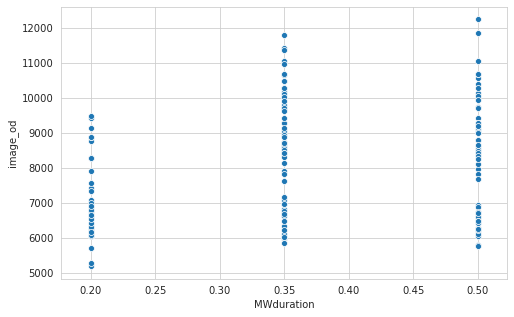

In [13]:
plt.figure(figsize=(8,5))
sns.scatterplot(x=data1.MWduration,y=sums,markers='O',hue_norm=(0,0.0015))

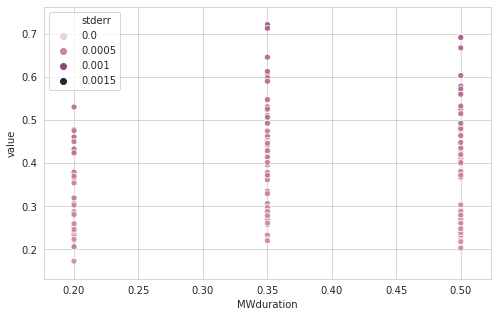

In [14]:
plt.figure(figsize=(8,5))
sns.scatterplot(x=data1.MWduration,y=data1.amp.value,hue = data.amp.stderr,markers='O',hue_norm=(0,0.0015))

In [15]:
results = pd.DataFrame()
data1['fitted_amp_binning'] =  pd.cut(data1.amp.value,bins = np.linspace(0.2,0.7,10))
grouping = data1.groupby('fitted_amp_binning')
results['averaged_od'] = grouping.apply(stderr_weighted_average)

/home/david/Downloads/.anaconda3/envs/mypy3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [16]:
fit = results['averaged_od'].apply(fit22dGaussian)
fit_res = fit.apply(fittoSeries)

In [17]:
data1=data1.sort_values(('amp','value'))

In [18]:
data1.rolling()

TypeError: rolling() missing 1 required positional argument: 'window'

In [ ]:
fit_res['3lvl_center_od'] = fit.apply(lambda x: x.eval((x.params['cen_x2'].value,x.params['cen_y2'].value)))
fit_res['3lvl_center_od_std'] = np.sqrt(np.square(fit_res.amp2.stderr) +np.square(fit_res.amp1.stderr**2))
fit_res['2lvl_center_od'] = fit_res['3lvl_center_od']-fit_res.amp2.value
fit_res['2lvl_center_od_std'] = fit_res.amp1.stderr
fit_res['3vs2lvl_od'] = fit_res['3lvl_center_od']/fit_res['2lvl_center_od']

In [ ]:
np.sqrt(4)

In [ ]:
def three_vs_two_lvl(n,r0,n0):
    fbl = n0*n**(4./5)
    return (r0 + fbl)/(1+fbl)
model = Model(three_vs_two_lvl)
params = model.make_params()
params['r0'].value = 0.66
params['n0'].value = 1

In [ ]:
out = model.fit(fit_res['3vs2lvl_od'].values,n=fit_res['2lvl_center_od'],params=params,nan_policy='omit')

In [ ]:
fit_res.plot(y="3vs2lvl_od",x="2lvl_center_od",style='o')
x=np.arange(0.2,0.8,0.01)
plt.plot(x,model.eval(n =x ,params=out.params))

In [ ]:
out.params

In [ ]:
for image in results.averaged_od:
    fig,ax = plt.subplots(figsize=(20,10))
    
    plt.imshow(image,vmin=0,vmax=1.5)

In [ ]:
for fit in results.fit:
    fit.fit_object
    fig,ax = plt.subplots(figsize=(20,10))
    fit.plot(ax=ax,image_kwargs=dict(vmin=0.,vmax=0.8))

In [ ]:
results=pd.DataFrame()
results['averaged_od'] = data.groupby('MWduration')['image_od'].apply(np.mean)
results['fit']=results['averaged_od'].apply(fit22dGaussian)
#results['par'] = results['fit'].apply(lambda x: x.params)
results['center_od_ratio'] = results['fit'].apply(center_od_ratio)
results['fitted_amp1'] = results['fit'].apply(lambda x: x.params['amp1'].value)
results['fitted_amp2'] = results['fit'].apply(lambda x: x.params['amp2'].value)

In [ ]:
results.center_od_ratio.plot(style='o')
#results.fitted_amp2.plot(style = 'o')

In [ ]:
results.plot(y='center_od_ratio',x='fitted_amp1',style='o')

In [ ]:
for fit in results.fit:
    fit.fit_object
    fig,ax = plt.subplots(figsize=(20,10))
    fit.plot(ax=ax,image_kwargs=dict(vmin=0.,vmax=0.8))